# Explaining cortical thickness development: ABCD CT data

Note: As ABCD data is under data protection, no ABCD data is included in this repo. To run this notebook on your own, you have to apply for [access](https://nda.nih.gov/abcd/request-access.html) to the ABCD dataset, download the tabulated summary datasets (~12GB) for [release 4.0](https://nda.nih.gov/general-query.html?q=query=featured-datasets:Adolescent%20Brain%20Cognitive%20Development%20Study%20(ABCD)) and release 3.0 and adjust the filepath of "abcd_data_dir". Release 3.0 is only used for the KSADS diagnostic data, which is not entirely included in release 4.0.  

For data protection, no individual-subject data are shown in this notebook. 

In [1]:
import os

import numpy as np
import pandas as pd
from functools import reduce
from tqdm.auto import tqdm

from os.path import join
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from scipy.stats import iqr

# custom function wrapping around PCNtoolkit/braincharts
from scripts.braincharts import get_adapted_predictions
from scripts.templates import get_destrieux
from scripts.utils import reorder_vars, na

# working path
wd = os.path.dirname(os.path.realpath("__file__"))
print("Working directory:", wd)

# ABCD data paths
abcd_data_dir = "/Users/llotter/data/abcd"
abcd_dir = join(wd, "data_ABCD-IMGN")

# cortical thickness model path
ct_model_dir = join(wd, "model_rutherford", "lifespan_57K_82sites")

Working directory: /Users/llotter/projects/ntct


## Get data

### IDPS

In [2]:
# parcel labels
destrieux_idps = get_destrieux()[1]
abcd_ct_parcels = pd.read_csv(join(abcd_data_dir, "_destrieux_parcels.csv"), header=None, index_col=0).\
    loc[[f"mrisdp_{i}" for i in range(1, 149)]]
abcd_idps_idx = abcd_ct_parcels.index.to_list()
abcd_idps = [i.split(",")[0].replace("smri_thick_cort.destrieux_","") for i in abcd_ct_parcels[7].to_list()]
idps_compare = pd.DataFrame(dict(
    abcd_idx=abcd_idps_idx,
    abcd_idp=abcd_idps,
    destrieux_idp=destrieux_idps
))
# check if same parcel order
for i in np.arange(0,148,20):
    display(idps_compare.iloc[i:i+2,:])

,abcd_idx,abcd_idp,destrieux_idp
0,mrisdp_1,g.and.s.frontomargin.lh,lh_G&S_frontomargin_thickness
1,mrisdp_2,g.and.s.occipital.inf.lh,lh_G&S_occipital_inf_thickness


,abcd_idx,abcd_idp,destrieux_idp
20,mrisdp_21,g.oc.temp.lat.fusifor.lh,lh_G_oc-temp_lat-fusifor_thickness
21,mrisdp_22,g.oc.temp.med.lingual.lh,lh_G_oc-temp_med-Lingual_thickness


,abcd_idx,abcd_idp,destrieux_idp
40,mrisdp_41,lat.fis.post.lh,lh_Lat_Fis-post_thickness
41,mrisdp_42,pole.occipital.lh,lh_Pole_occipital_thickness


,abcd_idx,abcd_idp,destrieux_idp
60,mrisdp_61,s.oc.temp.med.and.lingual.lh,lh_S_oc-temp_med&Lingual_thickness
61,mrisdp_62,s.orbital.lateral.lh,lh_S_orbital_lateral_thickness


,abcd_idx,abcd_idp,destrieux_idp
80,mrisdp_81,g.and.s.cingul.mid.ant.rh,rh_G&S_cingul-Mid-Ant_thickness
81,mrisdp_82,g.and.s.cingul.mid.post.rh,rh_G&S_cingul-Mid-Post_thickness


,abcd_idx,abcd_idp,destrieux_idp
100,mrisdp_101,g.parietal.sup.rh,rh_G_parietal_sup_thickness
101,mrisdp_102,g.postcentral.rh,rh_G_postcentral_thickness


,abcd_idx,abcd_idp,destrieux_idp
120,mrisdp_121,s.circular.insula.ant.rh,rh_S_circular_insula_ant_thickness
121,mrisdp_122,s.circular.insula.inf.rh,rh_S_circular_insula_inf_thickness


,abcd_idx,abcd_idp,destrieux_idp
140,mrisdp_141,s.postcentral.rh,rh_S_postcentral_thickness
141,mrisdp_142,s.precentral.inf.part.rh,rh_S_precentral-inf-part_thickness


### Create master dataset

- 777 = “Decline to answer”
- 999 = “Do not know”
- 888 = Question not asked due to primary question response (branching logic)
- 555 = Not administered in the assessment

#### Prepare keys for ABCD tables

In [3]:
# KSADS diagnosis keys
ksads_keys = pd.read_csv(join(abcd_data_dir, "r4.0", "abcd-4.0-data-dictionaries", "abcd_ksad501.csv"))
ksads_keys = ksads_keys.loc[
    [True if e.startswith("Symptom") | e.startswith("Diagnosis") \
        else False for e in ksads_keys.ElementDescription], 
    ["ElementName", "ElementDescription"]
]
ksads_keys =  ksads_keys.rename(columns=dict(ElementName="key_child", ElementDescription="desc")) \
    .reset_index(drop=True)
ksads_keys["key_parent"] = [k.replace("_t", "_p") for k in ksads_keys.key_child]
ksads_keys["desc_child"] = [d.replace("Diagnosis", "ksadsc_diag").replace("Symptom", "ksadsc_sympt") \
    for d in ksads_keys.desc]
ksads_keys["desc_parent"] = [d.replace("Diagnosis", "ksadsp_diag").replace("Symptom", "ksadsp_sympt") \
    for d in ksads_keys.desc]
# these dont exist:
ksads_keys.key_parent = ksads_keys.key_parent \
    .replace({"ksads_8_313a_p":"ksads_8_313_p", "ksads_8_313b_p":"ksads_8_313_p"})

# medical diagnosis keys
# c: brain injury, f: CP, h: epilepsy, k: lead poison, l: musculary distr, m: MS
mx_keys = ["medhx_2c", "medhx_2f", "medhx_2h", "medhx_2k", "medhx_2l", "medhx_2m"]

# traumatic brain injury keys
tbi_keys = ["tbi_ss_ntbiloc", "tbi_ss_agefirst", "tbi_ss_worst_overall"]

#### Load ABCD data tables

In [4]:
# dict of ABCD data tables w/ format "tablefile: variables"
abcd_tab_data = {
    join(abcd_data_dir, "r4.0", "abcd_mrisdp10201.txt"):        ["interview_age", "interview_date", "sex"] + abcd_idps_idx,
    join(abcd_data_dir, "r4.0", "abcd_smrip10201.txt"):         ["smri_vol_scs_wholeb", "smri_vol_scs_intracranialv"],
    join(abcd_data_dir, "r4.0", "abcd_fsurfqc01.txt"):          ["fsqc_qc"],
    join(abcd_data_dir, "r4.0", "abcd_auto_postqc01.txt"):      ["apqc_smri_topo_ndefect"],
    join(abcd_data_dir, "r4.0", "abcd_imgincl01.txt"):          ["imgincl_t1w_include"],
    join(abcd_data_dir, "r4.0", "abcd_lt01.txt"):               ["site_id_l"],
    join(abcd_data_dir, "r4.0", "abcd_meim01.txt"):             ["meim_ethnic_id_p"],
    join(abcd_data_dir, "r3.0", "abcd_ksad01.txt"):             ksads_keys.key_parent.to_list(),
    join(abcd_data_dir, "r3.0", "abcd_ksad501.txt"):            ksads_keys.key_child.to_list(),
    join(abcd_data_dir, "r4.0", "abcd_tbi01.txt"):              tbi_keys,
    join(abcd_data_dir, "r4.0", "abcd_mx01.txt"):               mx_keys,
}

# read data
abcd_tab = []
for k in abcd_tab_data.keys():
    tab = pd.read_csv(k, header=0, skiprows=[1], delimiter="\t", na_values=[555,777,888,999], 
                      low_memory=False)
    if ("visit" in tab.columns) & ("eventname" not in tab.columns):
        tab = tab.rename(columns=dict(visit="eventname"))
    if tab.eventname[0]=="screener_arm_1":
        tab.eventname = tab.eventname.replace({"screener_arm_1": "baseline_year_1_arm_1"})
    tab = tab[["subjectkey", "eventname"] + abcd_tab_data[k]]     
    abcd_tab.append(tab)
# combine data
abcd = reduce(lambda left, right: pd.merge(left, right, on=["subjectkey", "eventname"], how='left'), 
              abcd_tab)

#### Adjust and calculate new variables

In [5]:
## rename variables
abcd = abcd.rename(columns=dict(
    subjectkey="id", 
    interview_age="age_mon", 
    sex="sex_str", 
    eventname="tp",
    site_id_l="site_str"
))
abcd = abcd.rename(columns=dict(zip(abcd_idps_idx, destrieux_idps)))
abcd = abcd.rename(columns=dict(smri_vol_scs_wholeb="whole_brain_vol", 
                                smri_vol_scs_intracranialv="EstimatedTotalIntraCranialVol"))
abcd = abcd.rename(columns=dict(zip(ksads_keys.key_child, ksads_keys.desc_child)))
abcd = abcd.rename(columns=dict(zip(ksads_keys.key_parent, ksads_keys.desc_parent)))
abcd = abcd.rename(columns=dict(meim_ethnic_id_p="ethnic_parent"))

## "revalue"/add variables

# demographics
abcd["age"] = round(abcd.age_mon / 12, 2)
abcd["sex"] = [0 if s=="F" else 1 for s in abcd.sex_str] # F==0, M==1
abcd["site"] = [int(s[-2:]) for s in abcd.site_str] 
abcd.tp = abcd.tp.replace({
    "baseline_year_1_arm_1":    "T0",
    "2_year_follow_up_y_arm_1": "T2", 
    "4_year_follow_up_y_arm_1": "T4"
})
abcd.site_str = abcd.site_str.replace({
    'site01': "CHLA", 
    'site02': "CUB", 
    'site03': "FIU", 
    'site04': "LIBR", 
    'site05': "MUSC", 
    'site06': "OHSU",
    'site07': "ROC", 
    'site08': "SRI", 
    'site09': "UCLA", 
    'site10': "UCSD", 
    'site11': "UFL", 
    'site12': "UMB",
    'site13': "UMICH", 
    'site14': "UMN", 
    'site15': "UPMC", 
    'site16': "UTAH", 
    'site17': "UVM", 
    'site18': "UWM",
    'site19': "VCU", 
    'site20': "WUSTL", 
    'site21': "YALE", 
    'site22': "MSSM"
})
abcd.ethnic_parent = abcd.ethnic_parent.replace({
    1: "White",
    2: "Western European",
    3: "Eastern European",
    4: "Hispanic/Latino",
    5: "Black/African",
    6: "Afro-Carribean/Indo-Carribbean/West Indian",
    7: "East Asian",
    8: "South Asian",
    9: "Southeast Asian",
    10: "American Indian/Alaska Native",
    11: "Middle Eastern/North African",
    12: "Native Hawaiian/Pacific Islander",
    13: "Mixed Ethnicity",
    14: "Other Ethnicity",
    0: "None" 
})

# set index (id + tp)
abcd = abcd.set_index(["id", "tp"], drop=False)
abcd.index = abcd.index.set_names(names=["idx_id", "idx_tp"])
abcd = abcd.sort_index(axis="index")

# for definition of adaptation subjects: medical and psychiatric diagnoses
# if ==1 | ==True -> not TD
abcd["ksadsp_diag_any"] = (abcd[[c for c in abcd.columns if c.startswith("ksadsp_diag")]] == 1) \
    .any("columns")
abcd["ksadsc_diag_any"] = (abcd[[c for c in abcd.columns if c.startswith("ksadsc_diag")]] == 1) \
    .any("columns")
abcd["tbi_loc_any"] = abcd.tbi_ss_worst_overall >= 3 # mild, moderate or severe TBI (LOC -0.5, 0.5-24, >24h)
abcd["mx_any"] = (abcd[["medhx_2c", "medhx_2f", "medhx_2h", "medhx_2k", "medhx_2l", "medhx_2m"]] == 1) \
    .any("columns")

# remove some columns (a lot and we won't need these)
abcd = abcd[[c for c in abcd.columns if not (c.startswith("ksadsp_sympt") | c.startswith("ksadsc_sympt"))]] \
    .copy()

## reorder variables
abcd = reorder_vars(["id", "tp", "site", "site_str", "age", "age_mon", "sex", "sex_str"],
                    abcd, destrieux_idps)

#### Drop subjects

##### Missing data

In [6]:
# all
print(f"Whole dataset: baseline n = {len(abcd[abcd.tp=='T0'])},",
      f"2-year n = {len(abcd[abcd.tp=='T2'])}")

# drop site MSSM as was discontinued during baseline
abcd = abcd[abcd.site_str!="MSSM"].copy()
print(f"Site MSSM dropped: baseline n = {len(abcd[abcd.tp=='T0'])},",
      f"2-year n = {len(abcd[abcd.tp=='T2'])}")

# remove subjects with single missing CT values
missings = abcd[destrieux_idps].isnull().any(axis=1)
abcd = abcd[missings==False].copy()
print(f"Subjects with >=1 missing CT values dropped: baseline n = {len(abcd[abcd.tp=='T0'])},",
      f"2-year n = {len(abcd[abcd.tp=='T2'])}")

Whole dataset: baseline n = 11760, 2-year n = 7829
Site MSSM dropped: baseline n = 11728, 2-year n = 7829
Subjects with >=1 missing CT values dropped: baseline n = 11716, 2-year n = 7818


##### QC

We exclude subjects with a total Euler number of > Q3+1.5*IQR across cohorts or subjects flagged by ABCD internal QC.

In [7]:
qc_thresh = "iqr"

In [8]:
# all
print(f"Whole dataset: baseline n = {len(abcd[abcd.tp=='T0'])},",
      f"2-year n = {len(abcd[abcd.tp=='T2'])}")

# add filter based on topography
if qc_thresh=="quantile":
      thresh = np.quantile(abcd.apqc_smri_topo_ndefect, 0.99)
elif qc_thresh=="iqr":
      q3 = np.percentile(abcd.apqc_smri_topo_ndefect, 75)
      thresh = q3 + 1.5 * iqr(abcd.apqc_smri_topo_ndefect)
elif qc_thresh=="sd":
      mean = np.mean(abcd.apqc_smri_topo_ndefect)
      sd = np.std(abcd.apqc_smri_topo_ndefect)
      thresh = mean + 3*sd
abcd["topo_thresh"] = thresh
abcd["topo_outlier"] = [1 if defects>thresh else 0 \
      for defects, thresh in zip(abcd.apqc_smri_topo_ndefect, abcd.topo_thresh)]

# only subjects passing ABCD and FreeSurfer and topography defects quality control
abcd_preqc = abcd.copy()
abcd = abcd.query("(imgincl_t1w_include==1) & (fsqc_qc!=0) & (topo_outlier==0)").copy()
print(f"Post QC: baseline n = {len(abcd[abcd.tp=='T0'])},",
      f"2-year n = {len(abcd[abcd.tp=='T2'])}")

# drop subjects with only second tp or duplicate data
subs = list(abcd.id.unique())
missings = list()
for sub in subs:
      try:
            abcd.loc[(sub, "T0"), :]
      except:
            missings.append(sub)
      if len(abcd.loc[(sub, na()), :]) > 2:
            missings.append(sub)
abcd = abcd.loc[([s for s in subs if s not in missings], na()), :].copy() 
print(f"Subjects with only 2nd tp or duplicate data dropped: baseline n = {len(abcd[abcd.tp=='T0'])},",
      f"2-year n = {len(abcd[abcd.tp=='T2'])}")

# mark subjects with both time points
abcd["both_tp"] = False
for sub in abcd.id.unique(): 
      try:
            temp1 = abcd.loc[(sub,"T0"), :]
      except:
            continue
      try:
            temp2 = abcd.loc[(sub,"T2"), :]
      except:
            continue
      #if temp1.site==temp2.site:
      abcd.loc[(sub, na()), "both_tp"] = True
if len(abcd[(abcd.both_tp==1) & (abcd.tp=="T0")]) != \
      len(abcd[(abcd.both_tp==1) & (abcd.tp=="T2")]):
      print("Something is wrong!")
print(f"T0+T2 available: n = {len(abcd[abcd.both_tp==1])/2:.0f}")

Whole dataset: baseline n = 11716, 2-year n = 7818
Post QC: baseline n = 10697, 2-year n = 7378
Subjects with only 2nd tp or duplicate data dropped: baseline n = 10697, 2-year n = 6789
T0+T2 available: n = 6789


#### TD subjects for adaptation cohort definition

In [9]:
# any subject with medical or psychiatric diagnoses 
temp = \
      abcd.tbi_loc_any | \
      abcd.mx_any | \
      abcd.ksadsp_diag_any

# invert list -> True == TD
temp = ~temp

# list of all subjects
subs = list(abcd.id.unique())
subs_T2 = list(abcd[abcd.tp=="T2"].id.unique())
# iterate subjects
for sub in tqdm(subs):
      # a subject is TD if it was
      # - scanned at baseline & T2 and does not score on anything at baseline & T2
      # - only scanned at baseline & does not score on anything at baseline
      abcd.loc[(sub, na()), "td"] = "TD" if temp.loc[sub, na()].all() else "NTD"
      
print(f"TD: T0 n = {len(abcd[(abcd.td=='TD') & (abcd.tp=='T0')])}")
print(f"TD: T2 n = {len(abcd[(abcd.td=='TD') & (abcd.tp=='T2')])}")

  0%|          | 0/10697 [00:00<?, ?it/s]

TD: T0 n = 3153
TD: T2 n = 1778


#### Adaptation subjects

We select 20 adaptation subjects from each site: To retain more subjects for longitudinal analyses, we use only those that have no second time point. Subjects are taken from the "TD" cohort defined as having no severe medical or psychiatric condition. Selected subjects are stratified by age (grouped in 0.5-year bins) and split by sex (50/50)

In [10]:
# Find adaptation subjects
n_adapt = 20
print(f"Selecting n = {n_adapt} random adaption subjects from TDs, stratified on age, 50/50 male/female")

abcd["age_group"] = pd.cut(
    abcd.age, 
    bins=list(np.arange(8,15,0.5)),
    labels=[f">{i}<={i+0.5}" for i in np.arange(8,14.5,0.5)])

abcd["adapt"] = False
for site in range(1, 22):
    
    for sex in ["F", "M"]:
        
        temp = abcd.loc[(abcd.site==site) & (abcd.td=="TD") & (abcd.both_tp==False) & (abcd.tp=="T0") & (abcd.sex_str==sex), :].copy()
        for group in temp.age_group.unique():
            if len(temp[temp.age_group==group])==1:
                print(f"Dropping group {group}, n = {len(temp[temp.age_group==group])}")
                temp = temp[temp.age_group!=group]
        print(f"Site: {site}, n({sex}) = {len(temp)}")
        if len(temp) > int(n_adapt/2):
            adapt, _ = train_test_split(
                temp.id,
                stratify=temp["age_group"],
                train_size=int(n_adapt/2),
                random_state=42)
        else:
            adapt = temp.id 
        abcd.loc[(adapt.to_list(), "T0"), "adapt"] = True
    
    print(f"n(adapt) = {len(abcd[(abcd.site==site) & (abcd.adapt==True) & (abcd.tp=='T0')])}")
           
print("Number of adaptation subjects (tp's combined):", len(abcd.adapt[abcd.adapt==True]))

Selecting n = 20 random adaption subjects from TDs, stratified on age, 50/50 male/female
Site: 1, n(F) = 46
Dropping group >8.5<=9.0, n = 1
Site: 1, n(M) = 19
n(adapt) = 20
Site: 2, n(F) = 39
Dropping group >8.5<=9.0, n = 1
Site: 2, n(M) = 27
n(adapt) = 20
Site: 3, n(F) = 58
Site: 3, n(M) = 45
n(adapt) = 20
Dropping group >10.0<=10.5, n = 1
Site: 4, n(F) = 13
Dropping group >10.5<=11.0, n = 1
Site: 4, n(M) = 21
n(adapt) = 20
Site: 5, n(F) = 29
Site: 5, n(M) = 18
n(adapt) = 20
Site: 6, n(F) = 37
Site: 6, n(M) = 29
n(adapt) = 20
Dropping group >8.5<=9.0, n = 1
Site: 7, n(F) = 37
Site: 7, n(M) = 25
n(adapt) = 20
Dropping group >10.0<=10.5, n = 1
Site: 8, n(F) = 24
Site: 8, n(M) = 23
n(adapt) = 20
Site: 9, n(F) = 45
Site: 9, n(M) = 27
n(adapt) = 20
Site: 10, n(F) = 35
Site: 10, n(M) = 29
n(adapt) = 20
Site: 11, n(F) = 38
Site: 11, n(M) = 28
n(adapt) = 20
Site: 12, n(F) = 36
Site: 12, n(M) = 40
n(adapt) = 20
Site: 13, n(F) = 48
Site: 13, n(M) = 32
n(adapt) = 20
Dropping group >8.5<=9.0, n =

#### Sample stats

In [11]:
print("Overall number of unique subjects: n =", len(abcd.id.unique()))
print("Overall number of unique subjects with longitudinal data: n =", len(abcd[abcd.both_tp==True].id.unique()))

abcd["sex_str"] = pd.Categorical(abcd.sex_str)
abcd_sample_stats = dict()
for tp in ["T0", "T2"]:
    abcd_sample_stats[("Test", tp, "Age [y]")] = abcd.loc[(abcd.adapt==False) & (abcd.tp==tp) & (abcd.both_tp==True), "age"].describe()
    abcd_sample_stats[("Test", tp, "Male [%]")] = pd.Series({
        "count": len(abcd.loc[(abcd.adapt==False) & (abcd.tp==tp) & (abcd.both_tp==True)].sex_str),
        "%": len(abcd.loc[(abcd.adapt==False) & (abcd.tp==tp) & (abcd.both_tp==True) & (abcd.sex_str=="M")]),
    })
    if tp=="T0":
        abcd_sample_stats[("Adaptation", tp, "Age [y]")] = abcd.loc[(abcd.adapt==True) & (abcd.tp==tp), "age"].describe()
        abcd_sample_stats[("Adaptation", tp, "Male [%]")] = pd.Series({
            "count": len(abcd.loc[(abcd.adapt==True) & (abcd.tp==tp)].sex_str),
            "%": len(abcd.loc[(abcd.adapt==True) & (abcd.tp==tp) & (abcd.sex_str=="M")]),
        })
abcd_sample_stats = pd.DataFrame(abcd_sample_stats).sort_index(axis=1)
abcd_sample_stats = abcd_sample_stats.loc[["count", "mean", "%", "std", "50%", "min", "max"],:]
abcd_sample_stats = abcd_sample_stats.rename(index={"count":"n", "50%":"median", "std":"sd"})
abcd_sample_stats.loc["%",:] = abcd_sample_stats.loc["%",:] / abcd_sample_stats.loc["n",:] * 100
abcd_sample_stats = abcd_sample_stats.round(2)
abcd_sample_stats.to_csv(join(abcd_dir, "abcd_samplestats.csv"))
abcd_sample_stats

Overall number of unique subjects: n = 10697
Overall number of unique subjects with longitudinal data: n = 6789


Adaptation              Test                           
               T0                T0                T2         
          Age [y] Male [%]  Age [y] Male [%]  Age [y] Male [%]
n          420.00    420.0  6789.00  6789.00  6789.00  6789.00
mean         9.96      NaN     9.91      NaN    11.96      NaN
%             NaN     50.0      NaN    52.85      NaN    52.85
sd           0.63      NaN     0.62      NaN     0.65      NaN
median      10.00      NaN     9.92      NaN    11.92      NaN
min          8.92      NaN     8.92      NaN    10.58      NaN
max         11.00      NaN    11.08      NaN    13.75      NaN

#### Save dataframe

In [12]:
# reorder variables
abcd = reorder_vars(["id", "tp", "both_tp", "site", "site_str", "adapt", 
                     "age", "age_mon", "age_group", 
                     "sex", "sex_str",
                     "td"],
                    abcd, 
                    destrieux_idps)
# sort rows
abcd = abcd.sort_index(axis="index")
# save QC'd dataframe
abcd.reset_index().to_feather(join(abcd_dir, "abcd.ftr"))
# save adaptation subjects
pd.Series(abcd.query("adapt==True").id.unique()) \
    .to_csv(join(abcd_dir, "abcd_subjects_adapt.csv"), index=None, header=None)
pd.Series(abcd.query("(adapt==False) & (both_tp==True)").id.unique()) \
    .to_csv(join(abcd_dir, "abcd_subjects_test.csv"), index=None, header=None)

## Overview plots

### QC

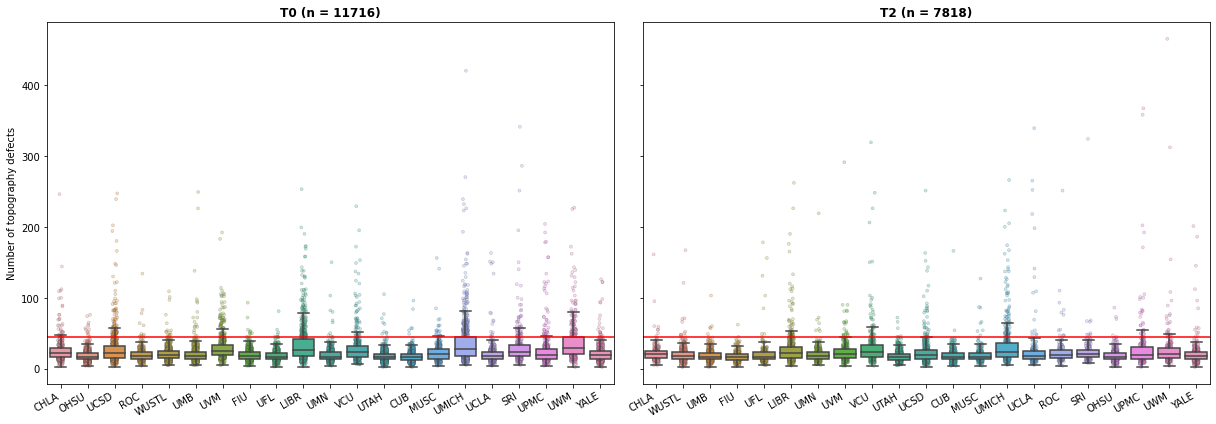

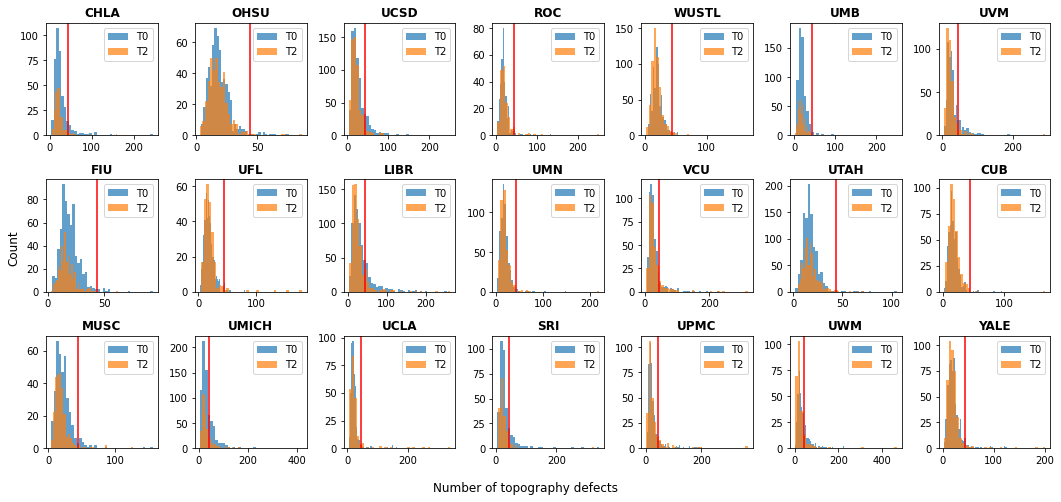

In [13]:
fig, axes = plt.subplots(1,2, figsize=(17,6), sharey=True)
for i, tp in enumerate(["T0", "T2"]):
    data = abcd_preqc.query("(tp==@tp)")
    sns.stripplot(
        y=data.apqc_smri_topo_ndefect, 
        x=data.site_str,
        ax=axes[i],
        alpha=0.3,
        linewidth=0.5,
        size=3,
        zorder=0
    )
    sns.boxplot(
        y=data.apqc_smri_topo_ndefect, 
        x=data.site_str,
        ax=axes[i],
        fliersize=0,
    )
    axes[i].set_title(f"{tp} (n = {len(data)})", weight="semibold")
    axes[i].set_ylabel("Number of topography defects" if tp=="T0" else "")
    axes[i].set_xlabel("")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=30, ha="right")
    axes[i].axhline(data.topo_thresh[0], c="red")     
plt.tight_layout()
fig.savefig(join(wd, "plots", "abcd-imgn", "qc_abcd_boxplots.pdf"))

fig, axes = plt.subplots(3,7, figsize=(15,7))
axes = axes.ravel()
for i, site in enumerate(abcd_preqc.site_str.unique()):
    for tp in ["T0", "T2"]:
        data = abcd_preqc.query("(tp==@tp) & (site_str==@site)")
        axes[i].hist(
            data.apqc_smri_topo_ndefect,
            bins=40,
            alpha=0.7,
            color="tab:blue" if tp=="T0" else "tab:orange",
            label=tp,
        )
        axes[i].set_title(site, weight="semibold")
        axes[i].legend()
    axes[i].axvline(data.topo_thresh[0], c="red")
fig.supylabel("Count")
fig.supxlabel("Number of topography defects")
fig.tight_layout()
fig.savefig(join(wd, "plots", "abcd-imgn", "qc_abcd_histograms.pdf"))

## Get predictions by Braincharts model

We use code adapted from the notebook associated with Rutherford et al., 2022.  
We adapt the normative models to the site effects of the ABCD FreeSurfer 7.1.1 data, make predictions for the new subjects, and use the models to adjust the original CT data from the ABCD subjects for site effects. 

Sources:  
Tutorial notebook: [https://pcntoolkit.readthedocs.io/en/latest/pages/apply_normative_models.html](https://pcntoolkit.readthedocs.io/en/latest/pages/apply_normative_models.html)  

### Predict & Adapt

In [14]:
# new dataframe without adaptation subjects
abcd_pred = abcd[abcd.adapt==0].copy()

# get datasets (adaptation + all others)
data_test = abcd[abcd.adapt==False]
data_adapt = abcd[(abcd.adapt==True) & (abcd.tp=="T0")]

data_pred = get_adapted_predictions(
    model_dir=ct_model_dir,
    data_test=data_test,
    data_adapt=data_adapt,
    cols_cov=["age", "sex"],
    col_site="site",
    age_bspline_min=-5, 
    age_bspline_max=110, 
    site_ids_tr=list(np.loadtxt(join(wd, "model_rutherford", "site_ids_82sites.txt"), dtype=str)), 
    idps=destrieux_idps + ["EstimatedTotalIntraCranialVol"])

Iterating IDPs:   0%|          | 0/149 [00:00<?, ?it/s]

IDP 0: lh_G&S_frontomargin_thickness
Preparing test data
Preparing adaptation data
Predict
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Adjust CT data for site effects
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
Saving results
IDP 1: lh_G&S_occipital_inf_thickness
Preparing test data
Preparing adaptation data
Predict
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Adjust CT data for site effects
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
Saving results
IDP 2: lh_G&S_paracentral_thickness
Preparing test data
Preparing adaptation data
Predict
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Adjust CT data for site effects
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
Saving results
IDP 3: lh_G&S_subcentral_

### Save dataframe

In [15]:
# join with predicted data
abcd_pred = abcd_pred.merge(data_pred.round(3), left_index=True, right_index=True, suffixes=("", "_DUPL"))
abcd_pred = abcd_pred.drop([c for c in abcd_pred.columns if c.endswith("_DUPL")], axis="columns")

# reorder variables
abcd_pred = reorder_vars(["id", "tp", "both_tp", "site", "site_str", "adapt", 
                          "age", "age_mon", "age_group", 
                          "sex", "sex_str",
                          "td"],
                         abcd_pred,
                         destrieux_idps)

# save predictor dataframe
abcd_pred.reset_index().to_feather(join(abcd_dir, "abcd_pred.ftr"))